# Augmenting PostgreSQL with AI using EvaDB
In this article, we illustrate how EvaDB seamlessly integrates AI into your PostgreSQL workflows for solving complex data manipulation tasks. In particular, we demonstrate how EvaDB enables AI-powered semantic join between tables that do not directly share a column that can be joined on.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/staging/tutorials/15-AI-powered-join.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/staging/tutorials/15-AI-powered-join.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/staging/tutorials/15-AI-powered-join.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

## Challenge: "AI-Powered" Join

![Without EvaDB](without_evadb_tutorial_15.png)

Consider a scenario where you have two tables - one with details about AirBnB listings in San Francisco and the other providing insights into the city's recreational parks. Our objective is to identify Airbnb listings located in neighborhoods with a high concentration of nearby parks. These datasets lack a common column for a straightforward join. The Airbnb dataset includes a 'neighborhood' column, while the parks dataset features a 'zip code' column.



![With EvaDB](with_evadb_tutorial_15.png)

EvaDB steps in to address this challenge by facilitating the merging operation using language models. Below shows the key query to create a new reference table that can be joined with other tables easily.

## Full Tutorial for using EvaDB

### Setup Postgres Database on Colab

In [1]:
!apt install -qqq postgresql
!service postgresql start

Preconfiguring packages ...
Selecting previously unselected package logrotate.
(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libcommon-sense-perl:amd64.
Preparing to unpack .../02-libcommon-sense-perl_3.75-2build1_amd64.deb ...
Unpacking libcommon-sense-perl:amd64 (3.75-2build1) ...
Selecting previously unselected package libjson-perl.
Preparing to unpack .../03-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package libtypes-serialiser-perl.
Preparing to unpack .../04-libtypes-serialiser-perl_1.01-1_all.deb ...
Unpacking libtypes-serialiser-perl (1.01-1) ...
Selecting previously unselected package libjson-xs-perl.
Preparing t

### Create User and Database

In [2]:
!sudo -u postgres psql -c "CREATE USER eva WITH SUPERUSER PASSWORD 'password'"
!sudo -u postgres psql -c "CREATE DATABASE airbnb"

CREATE ROLE
CREATE DATABASE


### Install EvaDB

In [4]:
%pip install --quiet "evadb[document]"
%pip install psycopg2

import evadb
cursor = evadb.connect().cursor()

  Cloning https://github.com/georgia-tech-db/evadb.git (to revision staging) to /tmp/pip-req-build-u86ke9a7
  Running command git clone --filter=blob:none --quiet https://github.com/georgia-tech-db/evadb.git /tmp/pip-req-build-u86ke9a7
  Resolved https://github.com/georgia-tech-db/evadb.git to commit 80e918d07432a020891896e76f7388df690a9699
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 880kB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [5]:
import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace("\\n","<br>")))

### Create Data Source in EvaDB
We use data source to connect EvaDB directly to underlying database systems like Postgres.

In [6]:
params = {
    "user": "eva",
    "password": "password",
    "host": "localhost",
    "port": "5432",
    "database": "airbnb",
}
query = f"CREATE DATABASE pg_db WITH ENGINE = 'postgres', PARAMETERS = {params};"
cursor.query(query).df()

,0
0,The database pg_db has been successfully created.


## Loading the Datasets

Our next step involves loading the dataset CSVs into our PostgreSQL database:

In [7]:
# Fetch the datasets

!mkdir -p content

!wget -nc -O /content/sf_recreational_parks.csv https://gist.github.com/gaurav274/2cb7ee709bf8900fc439fc2cc3f9edb6/raw/sf_recreational_parks.csv

!wget -nc -O /content/airbnb_listings.csv https://gist.github.com/gaurav274/9444867ed4b70af16c1863915c12dfe5/raw/airbnb_listings.csv

# Create the airbnb_listing table
cursor.query("""
          USE pg_db{
CREATE TABLE IF NOT EXISTS airbnb_listing (id INT, name VARCHAR(100), summary VARCHAR(1000), neighbourhood VARCHAR(100))}""").df()

# Load data into the airbnb_listing table
cursor.query("""
USE pg_db {
  COPY airbnb_listing(id, name, summary, neighbourhood)
  FROM '/content/airbnb_listings.csv'
  DELIMITER ',' CSV HEADER}
""").df()

# Create the recreational_park_dataset table
cursor.query("""
          USE pg_db{
CREATE TABLE IF NOT EXISTS recreational_park_dataset (parkName VARCHAR(100), ParkType VARCHAR(100), Zipcode INT)}""").df()


# Load data into the recreational_park_dataset table
cursor.query("""
USE pg_db {
  COPY recreational_park_dataset(parkName, ParkType, Zipcode)
  FROM '/content/sf_recreational_parks.csv'
  DELIMITER ',' CSV HEADER}
""").df()

--2023-09-06 04:11:19--  https://gist.github.com/gaurav274/2cb7ee709bf8900fc439fc2cc3f9edb6/raw/sf_recreational_parks.csv
Resolving gist.github.com (gist.github.com)... 140.82.112.3
Connecting to gist.github.com (gist.github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/gaurav274/2cb7ee709bf8900fc439fc2cc3f9edb6/raw/sf_recreational_parks.csv [following]
--2023-09-06 04:11:19--  https://gist.githubusercontent.com/gaurav274/2cb7ee709bf8900fc439fc2cc3f9edb6/raw/sf_recreational_parks.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11645 (11K) [text/plain]
Saving to: ‘/content/sf_recreational_parks.csv’

/content/sf_recreat 100%[===================>]  11.37K 

,status
0,success


### Use AI-Powered Queries in EvaDB

EvaDB bridges the semantic gap between the two tables using OpenAI's LLM model. We create a new 'reference' table to map San Francisco neighborhoods to their corresponding zip codes. First, we retrieve all distinct neighborhoods from our Airbnb listings.

In [21]:
neighbourhoods = cursor.query("""
USE pg_db {
  SELECT distinct(airbnb_listing.neighbourhood) from airbnb_listing}
""").df()

neighbourhoods_str = ', '.join(neighbourhoods['neighbourhood'])

prompt = f"Return the San Francisco neighbourhood name when provided with a zipcode.  The possible neighborhoods are: {neighbourhoods_str}. The response should an item from the provided list. Do not add any more words."
prompt

"Return the San Francisco neighbourhood name when provided with a zipcode.  The possible neighborhoods are: Civic Center, Duboce Triangle, Forest Hill, Tenderloin, SoMa, Outer Sunset, Financial District, Portola, Excelsior, Mission District, The Castro, Dogpatch, Hayes Valley, North Beach, Fisherman's Wharf, Richmond District, Haight-Ashbury, Union Square, Chinatown, Telegraph Hill, Sea Cliff, Potrero Hill, Oceanview, Downtown, Presidio Heights, South Beach, Balboa Terrace, Alamo Square, Mission Bay, Cole Valley, Twin Peaks, Bernal Heights, Crocker Amazon, Pacific Heights, Presidio, Parkside, Glen Park, West Portal, Sunnyside, Lower Haight, Lakeshore, Ingleside, Visitacion Valley, Noe Valley, Nob Hill, Mission Terrace, Bayview, Diamond Heights, Western Addition/NOPA, Inner Sunset, Marina, Cow Hollow, Russian Hill. The response should an item from the provided list. Do not add any more words."

Next, we use LLM to associate a zip code with each neighborhood.

In [47]:
import os
os.environ["OPENAI_KEY"] = "sk-..."

cursor.query(f"""CREATE TABLE reference_table AS SELECT parkname, parktype, ChatGPT("{prompt}",zipcode) FROM pg_db.recreational_park_dataset""").df()
cursor.query("Select * from reference_table;").df()

,reference_table2._row_id,reference_table2.parkname,reference_table2.parktype,reference_table2.response
0,1,10TH AVE/CLEMENT MINI PARK,Mini Park,Inner Sunset
1,2,15TH AVENUE STEPS,Mini Park,Outer Sunset
2,3,24TH/YORK MINI PARK,Mini Park,Mission District
3,4,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,Noe Valley
4,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
...,...,...,...,...
218,219,WILLIE WOO WOO WONG PLAYGROUND,Neighborhood Park or Playground,Nob Hill
219,220,WOH HEI YUEN PARK,Neighborhood Park or Playground,North Beach
220,221,Wolfe Lane Community Garden,Community Garden,Mission District
221,222,YACHT HARBOR AND MARINA GREEN,Regional Park,Marina


### Deriving insights using EvaDB
With our reference table prepared, it's time for the crucial step. We will now combine the reference table with the Airbnb listings to gain valuable insights into properties located nearest to the city's parks.

In [55]:
aggregated_table = cursor.query("select * from pg_db.airbnb_listing join reference_table ON airbnb_listing.neighbourhood = reference_table.response;").df()
aggregated_table

,airbnb_listing.id,airbnb_listing.name,airbnb_listing.summary,airbnb_listing.neighbourhood,reference_table2._row_id,reference_table2.parkname,reference_table2.parktype,reference_table2.response
0,110825,Charming Cottage with Bay View,None,Bayview,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
1,522273,Amazing Private Room w/View in Beautiful SF Flat,Large private room w/ amazing downtown views. ...,Bayview,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
2,631735,Comfy Room in SF Victorian house,The room we offer is in our Queen Ann Victoria...,Bayview,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
3,654279,Quiet Room in Our Friendly Home,Private room for up to two guests in our home ...,Bayview,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
4,782126,Great Rm In A Happy Household S.F.,This is a lovely room in a funky cool househol...,Bayview,5,ADAM ROGERS PARK,Neighborhood Park or Playground,Bayview
...,...,...,...,...,...,...,...,...
37437,21189031,Sunny Studio Apartment with Private Deck.,Noe Valley Studio - Prime Location - 2 blocks...,Noe Valley,218,White Crane Springs Community Garden,Community Garden,Noe Valley
37438,21398528,Iconic Victorian Architecture with City Views,Relish staying in this Victorian San Francisco...,Noe Valley,218,White Crane Springs Community Garden,Community Garden,Noe Valley
37439,21298312,Serene Victorian with Views in Noe Valley,Striking potted plants tower above a seafoam g...,Noe Valley,218,White Crane Springs Community Garden,Community Garden,Noe Valley
37440,21345382,"Light-filled, spacious family home with parking","Beautiful, spacious and light-filled house, wi...",Noe Valley,218,White Crane Springs Community Garden,Community Garden,Noe Valley


This aggregated table opens the door to various analytical possibilities. Below, we present a chart illustrating the number of parks in each neighborhood. This data can inform decisions when recommending potential Airbnb locations for individuals who enjoy staying in proximity to recreational parks.

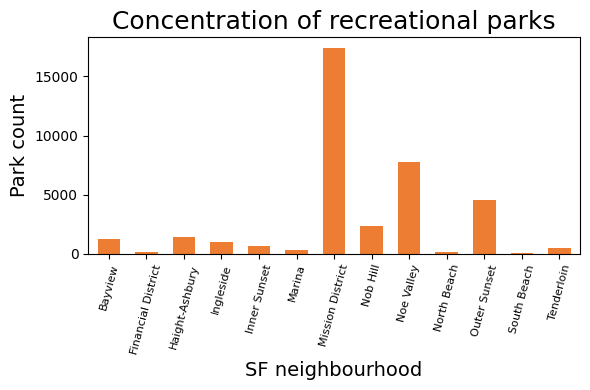

In [61]:
def plot(df):
    import matplotlib.pyplot as plt
    grouped = df.groupby(df.columns[3]).size().reset_index(name='count')

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    grouped.plot(kind='bar', x=grouped.columns[0], y=grouped.columns[1], ax=ax, legend=False, color='#ed7d32', width=0.6)

    plt.title('Concentration of recreational parks', fontsize=18)
    plt.xlabel('SF neighbourhood', fontsize=14)
    plt.ylabel('Park count', fontsize=14)


    # Set the font size for tick labels
    plt.xticks(rotation=75, fontsize=8)
    plt.tight_layout()
    plt.show()

plot(aggregated_table)